### 0. Imports and config

In [40]:
import os
import random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

SEED = 42
DATA_DIR = Path("../data/processed")
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 2  # pon 0 si te da problemas en Mac

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device


device(type='mps')

### 1. Transforms + dataset

In [41]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(DATA_DIR/"train", transform=train_tfms)
val_ds   = datasets.ImageFolder(DATA_DIR/"val", transform=eval_tfms)
test_ds  = datasets.ImageFolder(DATA_DIR/"test", transform=eval_tfms)

class_names = train_ds.classes
num_classes = len(class_names)
class_names, num_classes


(['Dresses', 'Graphic_Tees', 'Pants', 'Shorts', 'Skirts'], 5)

### 2. Dataloaders

In [42]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


### 3. Model

In [43]:
from collections import Counter

counts = Counter(train_ds.targets)
total = sum(counts.values())
weights = torch.tensor([total / counts[i] for i in range(num_classes)], dtype=torch.float32).to(device)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


### 4. Train/ eval loops

In [44]:
def run_epoch(model, loader, train=False):
    model.train(train)
    total_loss, correct, n = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        n += x.size(0)

    return total_loss / n, correct / n

EPOCHS = 5
best_val = 0.0
best_path = "models/resnet18_deepfashion.pt"
os.makedirs("models", exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_epoch(model, val_loader, train=False)

    if va_acc > best_val:
        best_val = va_acc
        torch.save(model.state_dict(), best_path)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
print("Best val acc:", best_val)


Epoch 01 | train loss 0.6657 acc 0.727 | val loss 0.2925 acc 0.898
Epoch 02 | train loss 0.2148 acc 0.923 | val loss 0.3312 acc 0.888
Epoch 03 | train loss 0.1426 acc 0.947 | val loss 0.2066 acc 0.936
Epoch 04 | train loss 0.0609 acc 0.983 | val loss 0.2056 acc 0.932
Epoch 05 | train loss 0.0579 acc 0.980 | val loss 0.1876 acc 0.941
Best val acc: 0.9411764705882353


### 5. Test and class metrics

/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_97146/3240744331.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, m

              precision    recall  f1-score   support

     Dresses      0.966     0.934     0.950       273
Graphic_Tees      0.870     0.930     0.899        43
       Pants      0.969     0.912     0.939        68
      Shorts      0.956     0.948     0.952       115
      Skirts      0.787     0.913     0.846        69

    accuracy                          0.931       568
   macro avg      0.910     0.927     0.917       568
weighted avg      0.935     0.931     0.932       568



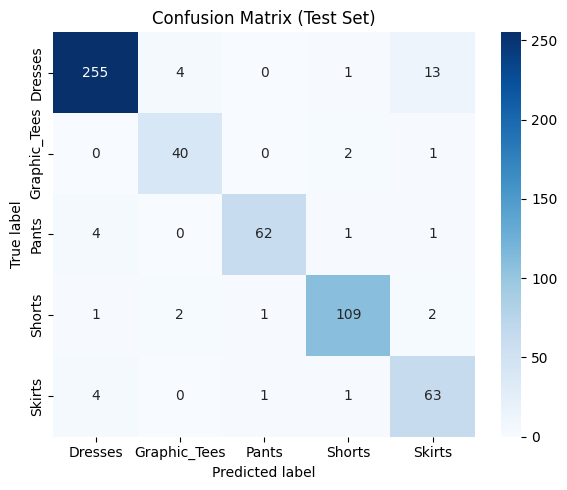

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best model
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

all_preds, all_y = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_y.extend(y.numpy())

# Classification report
print(classification_report(all_y, all_preds, target_names=class_names, digits=3))

# Confusion matrix
cm = confusion_matrix(all_y, all_preds)

# Plot confusion matrix as image
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


### 6. Load Model

In [46]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

idx2class = {v:k for k,v in train_ds.class_to_idx.items()}

def denorm(img_t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    x = img_t.cpu() * std + mean
    return x.clamp(0, 1)


/var/folders/7x/lsf3fbc14ldfy85pcnmhcm3m0000gn/T/ipykernel_97146/1756715857.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, m

### 7. Grad CAM for Resnet18 and visualization

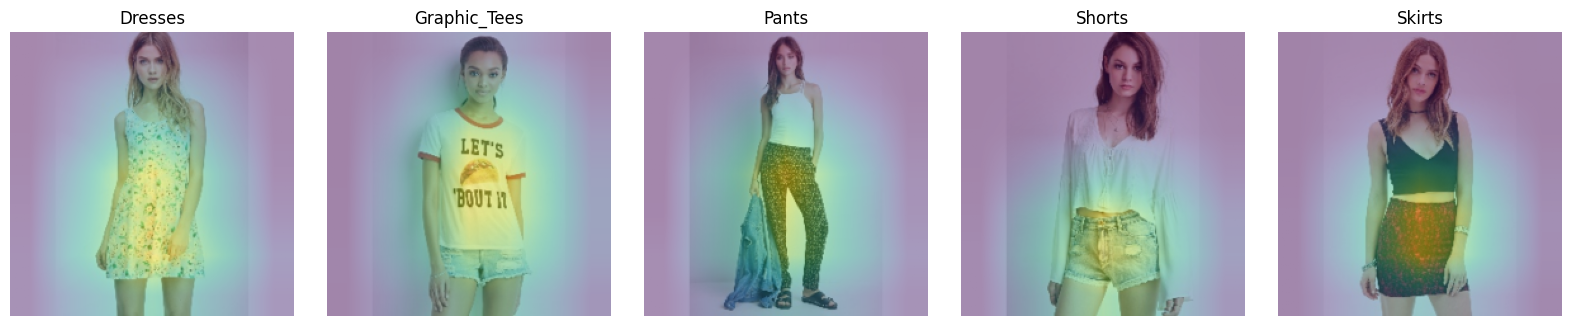

In [62]:
# Grad-CAM++ (for ResNet18). Assumes: model, device, denorm(), idx2class exist.

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.h1 = target_layer.register_forward_hook(self._forward_hook)
        self.h2 = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(1).item()

        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        A  = self.activations            # [1, C, H, W]
        dA = self.gradients              # [1, C, H, W]

        dA2 = dA ** 2
        dA3 = dA ** 3
        eps = 1e-8

        denom = (2 * dA2 + (A * dA3).sum(dim=(2, 3), keepdim=True) + eps)
        alpha = dA2 / denom

        w = (alpha * F.relu(dA)).sum(dim=(2, 3), keepdim=True)

        cam = (w * A).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
        cam = cam[0, 0]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return logits.detach(), cam.detach()

    def close(self):
        self.h1.remove()
        self.h2.remove()

cam_pp = GradCAMPlusPlus(model, model.layer4[-1])

import random
import torch
import matplotlib.pyplot as plt

def _collect_correct_indices_by_class(ds, max_tries=20000):
    """
    Collect indices i where (y==c and pred==y) for each class c.
    Returns: dict c -> list of indices
    """
    model.eval()
    num_classes = len(idx2class)
    correct = {c: [] for c in range(num_classes)}

    n = min(len(ds), max_tries)
    for i in range(n):
        x, y = ds[i]
        x1 = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x1).argmax(1).item()
        if pred == y:
            correct[y].append(i)

    return correct

def show_one_correct_per_class_cam_pp_random(ds, seed=None, max_tries=20000):
    """
    Each call selects a random well-classified example per class and plots them in one row.
    If seed is None -> different random samples each run.
    """
    if seed is not None:
        random.seed(seed)

    correct = _collect_correct_indices_by_class(ds, max_tries=max_tries)

    num_classes = len(idx2class)
    chosen = {}
    for c in range(num_classes):
        if len(correct[c]) == 0:
            chosen[c] = None
        else:
            chosen[c] = random.choice(correct[c])

    fig, axes = plt.subplots(1, num_classes, figsize=(3.2 * num_classes, 3.2))
    if num_classes == 1:
        axes = [axes]

    for c, ax in enumerate(axes):
        i = chosen[c]
        if i is None:
            ax.set_title(f"{idx2class[c]}\n(no correct found)")
            ax.axis("off")
            continue

        x, y = ds[i]
        x1 = x.unsqueeze(0).to(device)

        with torch.enable_grad():
            logits, heat = cam_pp(x1)

        pred = logits.argmax(1).item()
        p_pred = torch.softmax(logits, 1)[0, pred].item()

        img = denorm(x).permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.imshow(heat.cpu().numpy(), alpha=0.45)
        ax.set_title(f"{idx2class[y]}")# \nPred={idx2class[pred]} ({p_pred:.2f})")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Usage (different random examples each run):
show_one_correct_per_class_cam_pp_random(test_ds)

# Optional deterministic run:
# show_one_correct_per_class_cam_pp_random(test_ds, seed=42)


### 8. Identifying missclassification

In [64]:
def get_preds(ds):
    loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
    preds, ys, probs = [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            p = torch.softmax(logits, 1)
            preds.extend(p.argmax(1).cpu().numpy())
            ys.extend(y.numpy())
            probs.extend(p.max(1).values.cpu().numpy())
    return np.array(preds), np.array(ys), np.array(probs)

preds, ys, probs = get_preds(test_ds)

dress = train_ds.class_to_idx["Dresses"]
skirt = train_ds.class_to_idx["Skirts"]

mis_idx = np.where((ys == dress) & (preds == skirt))[0]
len(mis_idx), mis_idx[:10]

(13, array([ 58,  68,  74,  88,  94, 145, 169, 176, 177, 188]))

In [67]:
def show_cam_pp_misclassified_row(ds, indices):
    """
    Show multiple misclassified examples with Grad-CAM++ in a single row.
    """
    fig, axes = plt.subplots(1, len(indices), figsize=(3.5 * len(indices), 3.5))

    if len(indices) == 1:
        axes = [axes]

    for ax, i in zip(axes, indices):
        x, y = ds[int(i)]
        x1 = x.unsqueeze(0).to(device)

        with torch.enable_grad():
            logits, heat = cam_pp(x1)

        pred = logits.argmax(1).item()
        p_pred = torch.softmax(logits, 1)[0, pred].item()

        img = denorm(x).permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.imshow(heat.cpu().numpy(), alpha=0.45)

        ax.set_title(
            f"True: {idx2class[y]}\nPred: {idx2class[pred]} ({p_pred:.2f})",
            fontsize=10
        )
        ax.axis("off")

    plt.tight_layout()
    plt.show()


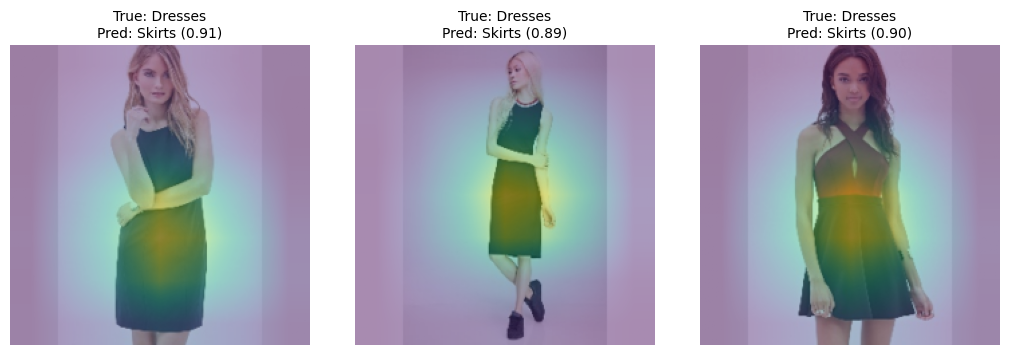

In [ ]:
# Show 3 Dresses → Skirts misclassifications 
show_cam_pp_misclassified_row(test_ds, mis_idx[:3])



### 10. Obtaining Global Heatmaps

In [80]:
def cam_pp_for_index(ds, idx, class_idx=None):
    x, y = ds[idx]
    x1 = x.unsqueeze(0).to(device)
    with torch.enable_grad():
        logits, heat = cam_pp(x1, class_idx=class_idx)
    pred = logits.argmax(1).item()
    p_pred = torch.softmax(logits, 1)[0, pred].item()
    return heat.cpu().numpy(), y, pred, p_pred


In [81]:
import numpy as np
import matplotlib.pyplot as plt

def average_heatmap_for_indices(ds, indices, max_n=50):
    if len(indices) == 0:
        return None
    sel = indices[:min(len(indices), max_n)]
    hs = []
    for idx in sel:
        h, y, pred, p = cam_pp_for_index(ds, int(idx))
        hs.append(h)
    return np.mean(np.stack(hs, axis=0), axis=0)

def show_avg_heatmaps_row(avg_heats, titles):
    """
    avg_heats: list of averaged heatmaps (numpy arrays)
    titles: list of titles (same length)
    """
    n = len(avg_heats)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    if n == 1:
        axes = [axes]

    for ax, heat, title in zip(axes, avg_heats, titles):
        if heat is None:
            ax.set_title("No data")
            ax.axis("off")
            continue

        ax.imshow(heat)
        ax.set_title(title, fontsize=11)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# ids de clases
dress = train_ds.class_to_idx["Dresses"]
skirt = train_ds.class_to_idx["Skirts"]

# usando preds, ys que ya calculaste antes
idx_skirt_correct = np.where((ys == skirt) & (preds == skirt))[0]
idx_dress_correct = np.where((ys == dress) & (preds == dress))[0]
idx_dress_to_skirt = np.where((ys == dress) & (preds == skirt))[0]

avg_skirt_correct = average_heatmap_for_indices(test_ds, idx_skirt_correct, max_n=50)
avg_dress_correct = average_heatmap_for_indices(test_ds, idx_dress_correct, max_n=50)
avg_dress_to_skirt = average_heatmap_for_indices(test_ds, idx_dress_to_skirt, max_n=50)

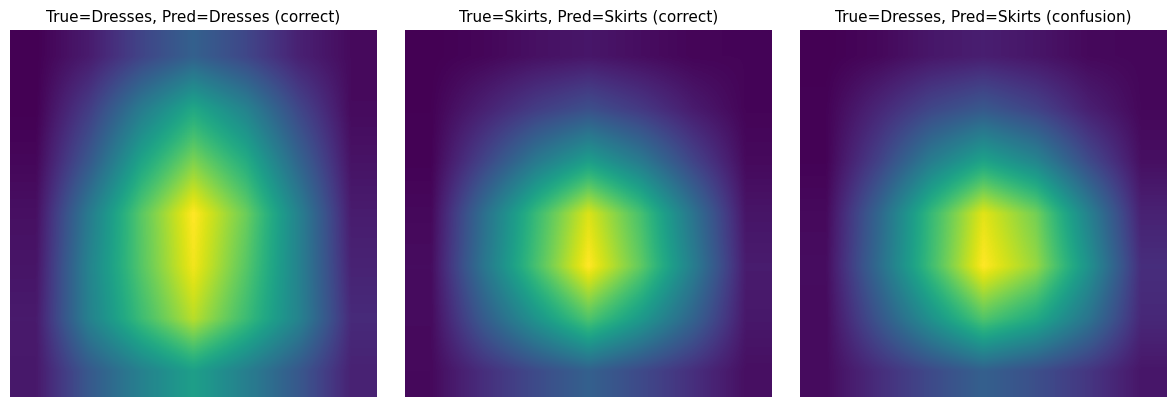

In [82]:
show_avg_heatmaps_row(
    avg_heats=[
        avg_dress_correct,
        avg_skirt_correct,
        avg_dress_to_skirt
    ],
    titles=[
        "True=Dresses, Pred=Dresses (correct)",
        "True=Skirts, Pred=Skirts (correct)",
        "True=Dresses, Pred=Skirts (confusion)"
    ]
)


### 12. Sanity Check

In [83]:
# random model with same architecture
rand_model = models.resnet18(weights=None)
rand_model.fc = nn.Linear(rand_model.fc.in_features, num_classes)
rand_model = rand_model.to(device)
rand_model.eval()

cam_pp_rand = GradCAMPlusPlus(rand_model, rand_model.layer4[-1])

def show_sanity(ds, i):
    x, y = ds[i]
    x1 = x.unsqueeze(0).to(device)

    with torch.enable_grad():
        logits_t, heat_t = cam_pp(x1)            
        logits_r, heat_r = cam_pp_rand(x1)         

    pred_t = logits_t.argmax(1).item()
    pred_r = logits_r.argmax(1).item()

    img = denorm(x).permute(1,2,0)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(f"Image | True={idx2class[y]}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(img)
    plt.imshow(heat_t.cpu().numpy(), alpha=0.45)
    plt.title(f"Trained CAM++ | Pred={idx2class[pred_t]}")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.imshow(heat_r.cpu().numpy(), alpha=0.45)
    plt.title(f"Random CAM++ | Pred={idx2class[pred_r]}")
    plt.axis("off")

    plt.show()



In [84]:
def find_correct_index(ds, max_tries=500):
    model.eval()
    for i in range(min(len(ds), max_tries)):
        x, y = ds[i]
        x1 = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x1).argmax(1).item()
        if pred == y:
            return i
    return None

i_ok = find_correct_index(test_ds)
i_ok


0

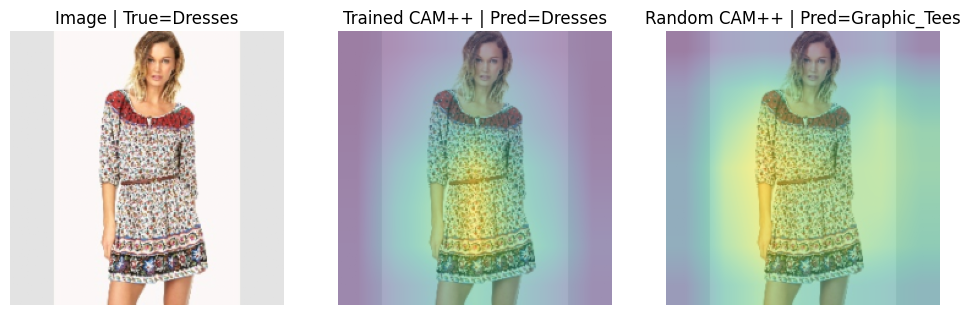

In [85]:
show_sanity(test_ds, i_ok)
